In [2]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 9.6 MB/s eta 0:00:00


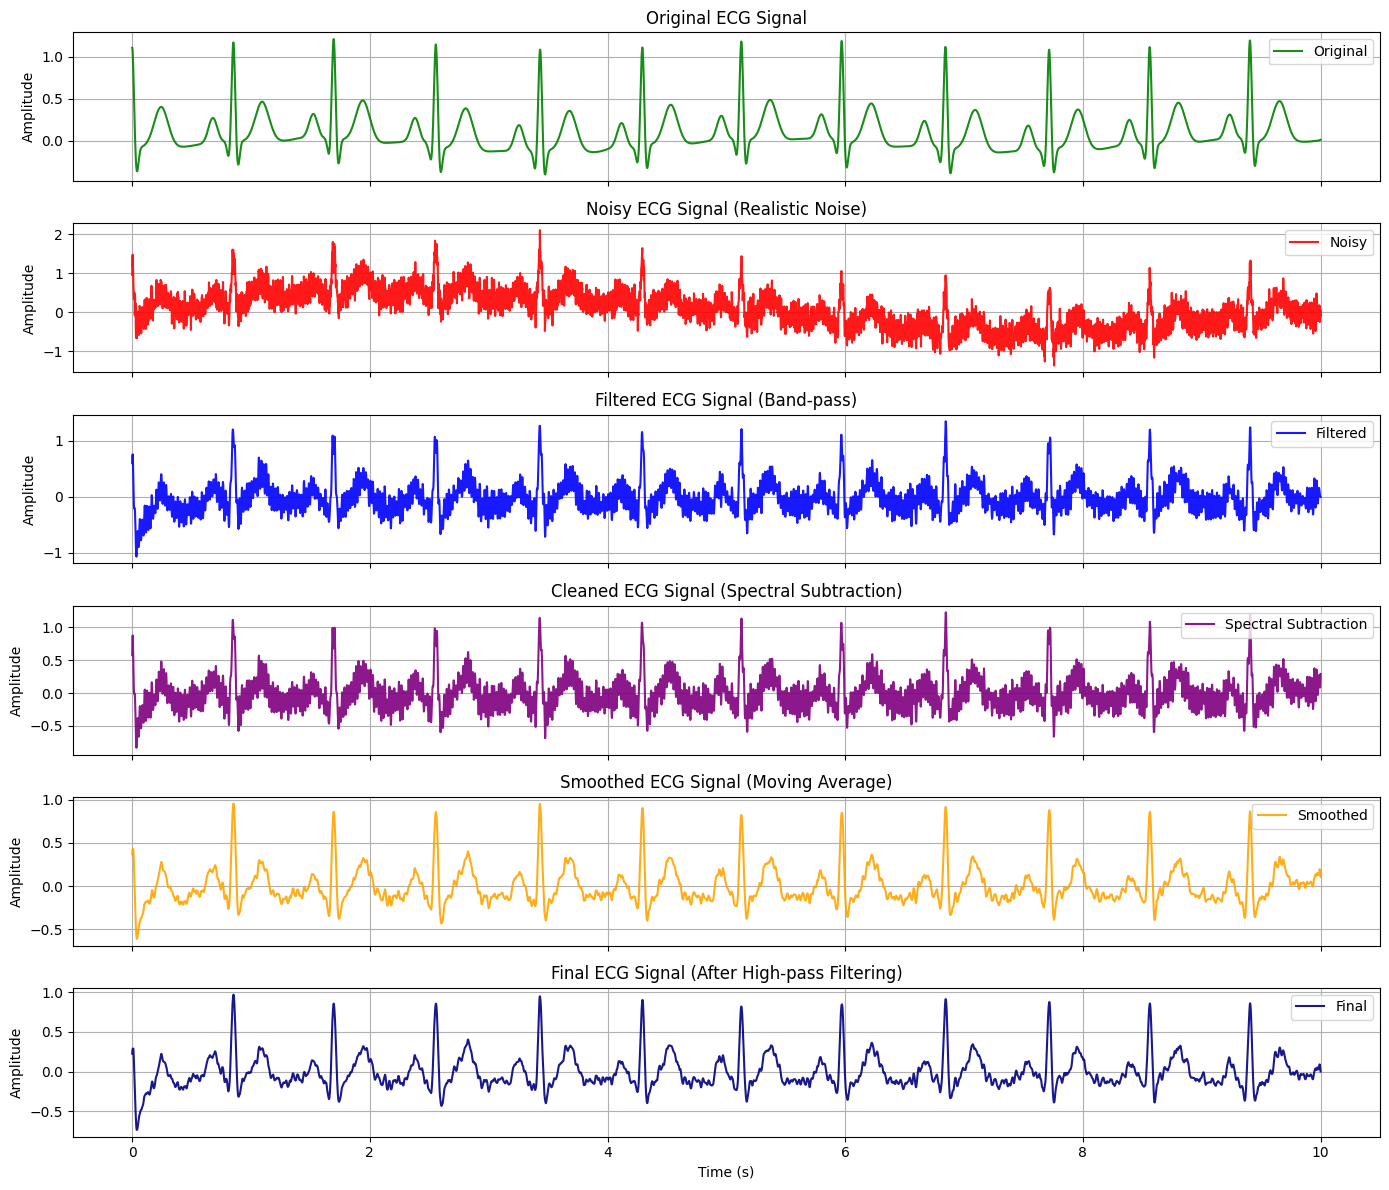

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, iirnotch
from numpy.fft import fft, ifft
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler


def generate_ecg_signal(duration=10, fs=500):
    ecg_signal = nk.ecg_simulate(duration=duration, sampling_rate=fs)
    t = np.linspace(0, duration, len(ecg_signal))
    return t, ecg_signal

fs = 500
duration = 10
t, ecg_signal = generate_ecg_signal(duration, fs)


def add_realistic_noise(ecg, fs):
    baseline_wander = 0.5 * np.sin(2 * np.pi * 0.1 * np.arange(len(ecg)) / fs)
    powerline_noise = 0.2 * np.sin(2 * np.pi * 50 * np.arange(len(ecg)) / fs)
    white_noise = np.random.normal(0, 0.15, len(ecg))
    noisy_ecg = ecg + baseline_wander + powerline_noise + white_noise
    return noisy_ecg
noisy_ecg = add_realistic_noise(ecg_signal, fs)

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, padlen=0)
filtered_ecg = bandpass_filter(noisy_ecg, 0.5, 70, fs)


def spectral_subtraction(signal, noise, alpha=0.3, spectral_floor=0.1):
    max_len = len(signal)
    if len(noise) < max_len:
        noise = np.pad(noise, (0, max_len - len(noise)), 'constant')
    signal_fft = fft(signal)
    noise_fft = fft(noise)
    signal_mag = np.abs(signal_fft)
    noise_mag = np.abs(noise_fft)
    phase = np.angle(signal_fft)
    cleaned_mag = np.maximum(signal_mag - alpha * noise_mag, spectral_floor * signal_mag)
    cleaned_fft = cleaned_mag * np.exp(1j * phase)
    cleaned_signal = np.real(ifft(cleaned_fft))

    return cleaned_signal


noise_sample = noisy_ecg[fs:2*fs]


cleaned_ecg = spectral_subtraction(filtered_ecg, noise_sample)


def moving_average(signal, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(signal, window, mode='same')

smoothed_ecg = moving_average(cleaned_ecg, window_size=10)

def highpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high')
    return filtfilt(b, a, data, padlen=0)

final_ecg = highpass_filter(smoothed_ecg, 0.5, fs)
fig, axs = plt.subplots(6, 1, figsize=(14, 12), sharex=True)
def plot_signal(ax, signal, title, label, color, alpha=0.9):
    ax.plot(t, signal, label=label, color=color, alpha=alpha)
    ax.set_title(title)
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.legend()

plot_signal(axs[0], ecg_signal, 'Original ECG Signal', 'Original', 'green')
plot_signal(axs[1], noisy_ecg, 'Noisy ECG Signal (Realistic Noise)', 'Noisy', 'red')
plot_signal(axs[2], filtered_ecg, 'Filtered ECG Signal (Band-pass)', 'Filtered', 'blue')
plot_signal(axs[3], cleaned_ecg, 'Cleaned ECG Signal (Spectral Subtraction)', 'Spectral Subtraction', 'purple')
plot_signal(axs[4], smoothed_ecg, 'Smoothed ECG Signal (Moving Average)', 'Smoothed', 'orange')
plot_signal(axs[5], final_ecg, 'Final ECG Signal (After High-pass Filtering)', 'Final', 'navy')

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()
